In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn with the goal of characterising customers who churn and building a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook are to:
* look for significant clusters within the churn data - you might look separately at those who churn and those who don't or group them all together. 
* try to build and evaluate a predictive model for churn - predict the value of the CHURN_IND field in the data from some of the other fields


**Action:** Read the CSV file and format the no-available values

In [2]:
churn = pd.read_csv(os.path.join("files","MobileCustomerChurn.csv"), na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


### 1) Summary Statistics

- To get a top-level summary of the numerical variables

In [3]:
churn.describe()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
count,46206.000000,46206.000000,46206.000000,46130.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,28416.000000,28416.000000,28416.000000
mean,42335.196879,45.874627,1.555707,41.411836,50.318617,51.364858,10.846708,8.237112,20.349825,15.249968,0.385015,75.188029,0.014640,0.191125,0.007038
std,22100.432751,33.077927,0.835529,15.263726,51.925537,20.855419,9.769887,8.341476,8.034631,10.982958,0.486604,73.519041,0.120108,0.393194,0.083600
min,1.000000,0.000000,1.000000,-4.000000,0.000000,8.180000,0.000000,0.000000,0.000000,0.000000,0.000000,1.020000,0.000000,0.000000,0.000000
25%,24951.750000,14.000000,1.000000,28.000000,11.000000,36.360000,3.000000,0.000000,24.000000,0.000000,0.000000,36.360000,0.000000,0.000000,0.000000
50%,43261.000000,44.000000,1.000000,40.000000,35.000000,54.540000,8.000000,7.000000,24.000000,24.000000,0.000000,54.540000,0.000000,0.000000,0.000000
75%,61132.750000,77.000000,2.000000,52.000000,69.000000,72.720000,16.000000,16.000000,24.000000,24.000000,1.000000,84.530000,0.000000,0.000000,0.000000
max,79500.000000,120.000000,4.000000,116.000000,259.000000,234.540000,147.000000,24.000000,36.000000,36.000000,1.000000,1965.890000,1.000000,1.000000,1.000000


In [4]:
churn.shape

(46206, 21)

## 2) Data cleaning

- There are negative values for some variables: AGE
- Review these negative values and remove them from the dataframe if necessary

### 2.1) Age

- Based on the boxplot, there are some rows where AGE is below 0
- Remove those from the dataframe, as they would add unneccesary noise to the anaysis

**Action:** Plot a boxplot on AGE column

Text(0.5, 1.0, 'Distribution of Age')

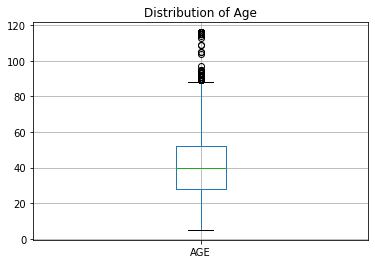

In [84]:
churn.boxplot(column = ['AGE']) 
plt.title('Distribution of Age')

**Action:** Remove AGE rows where value is less than 0

In [6]:
churn = churn[churn['AGE'] > 0]
# Check that mean of AGE is not negative anymore
#print(churn.describe())

(46128,)


**Action:** Check the updated number of rows

In [85]:
churn['AGE'].shape

(46127,)

**Action:** Check that mean of AGE is not negative anymore

In [86]:
churn.describe()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,...,MONTHLY_SPEND,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH,CFU_level,levels_BYO_PLAN_STATUS_level,levels_CONTRACT_STATUS_level,levels_HANDSET_USED_BRAND_level,levels_COUNTRY_METRO_REGION_level,levels_STATE_level
count,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,...,46127.000000,28365.000000,28365.000000,28365.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000
mean,42336.772498,45.886856,1.554426,41.413576,50.364234,51.361234,10.850890,8.235090,20.351118,15.253192,...,75.169090,0.014666,0.191468,0.007051,0.152839,0.232337,0.848462,1.116266,0.688599,2.082338
std,22102.538850,33.073946,0.834363,15.261213,51.943989,20.854056,9.771842,8.339843,8.032833,10.981573,...,73.393772,0.120214,0.393464,0.083675,0.359836,0.422327,0.604130,1.198880,0.463071,1.412337
min,1.000000,0.000000,1.000000,5.000000,0.000000,8.180000,0.000000,0.000000,0.000000,0.000000,...,1.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24950.000000,14.000000,1.000000,28.000000,11.000000,36.360000,3.000000,0.000000,24.000000,0.000000,...,36.360000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,43262.000000,44.000000,1.000000,40.000000,35.000000,54.540000,8.000000,7.000000,24.000000,24.000000,...,54.540000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000
75%,61136.500000,77.000000,2.000000,52.000000,69.000000,72.720000,16.000000,16.000000,24.000000,24.000000,...,84.530000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000
max,79500.000000,120.000000,4.000000,116.000000,259.000000,234.540000,147.000000,24.000000,36.000000,36.000000,...,1965.890000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,5.000000,1.000000,7.000000


All numerical variables now have positive values

## 3) Summary Plot of Distribution

- Pairplot to get a top-level view of relationships between numerical variables
- There does not seem to be any clear relationship between any variables

**Action:** Review pairplot of all columns to observe for any clear relationships between variables

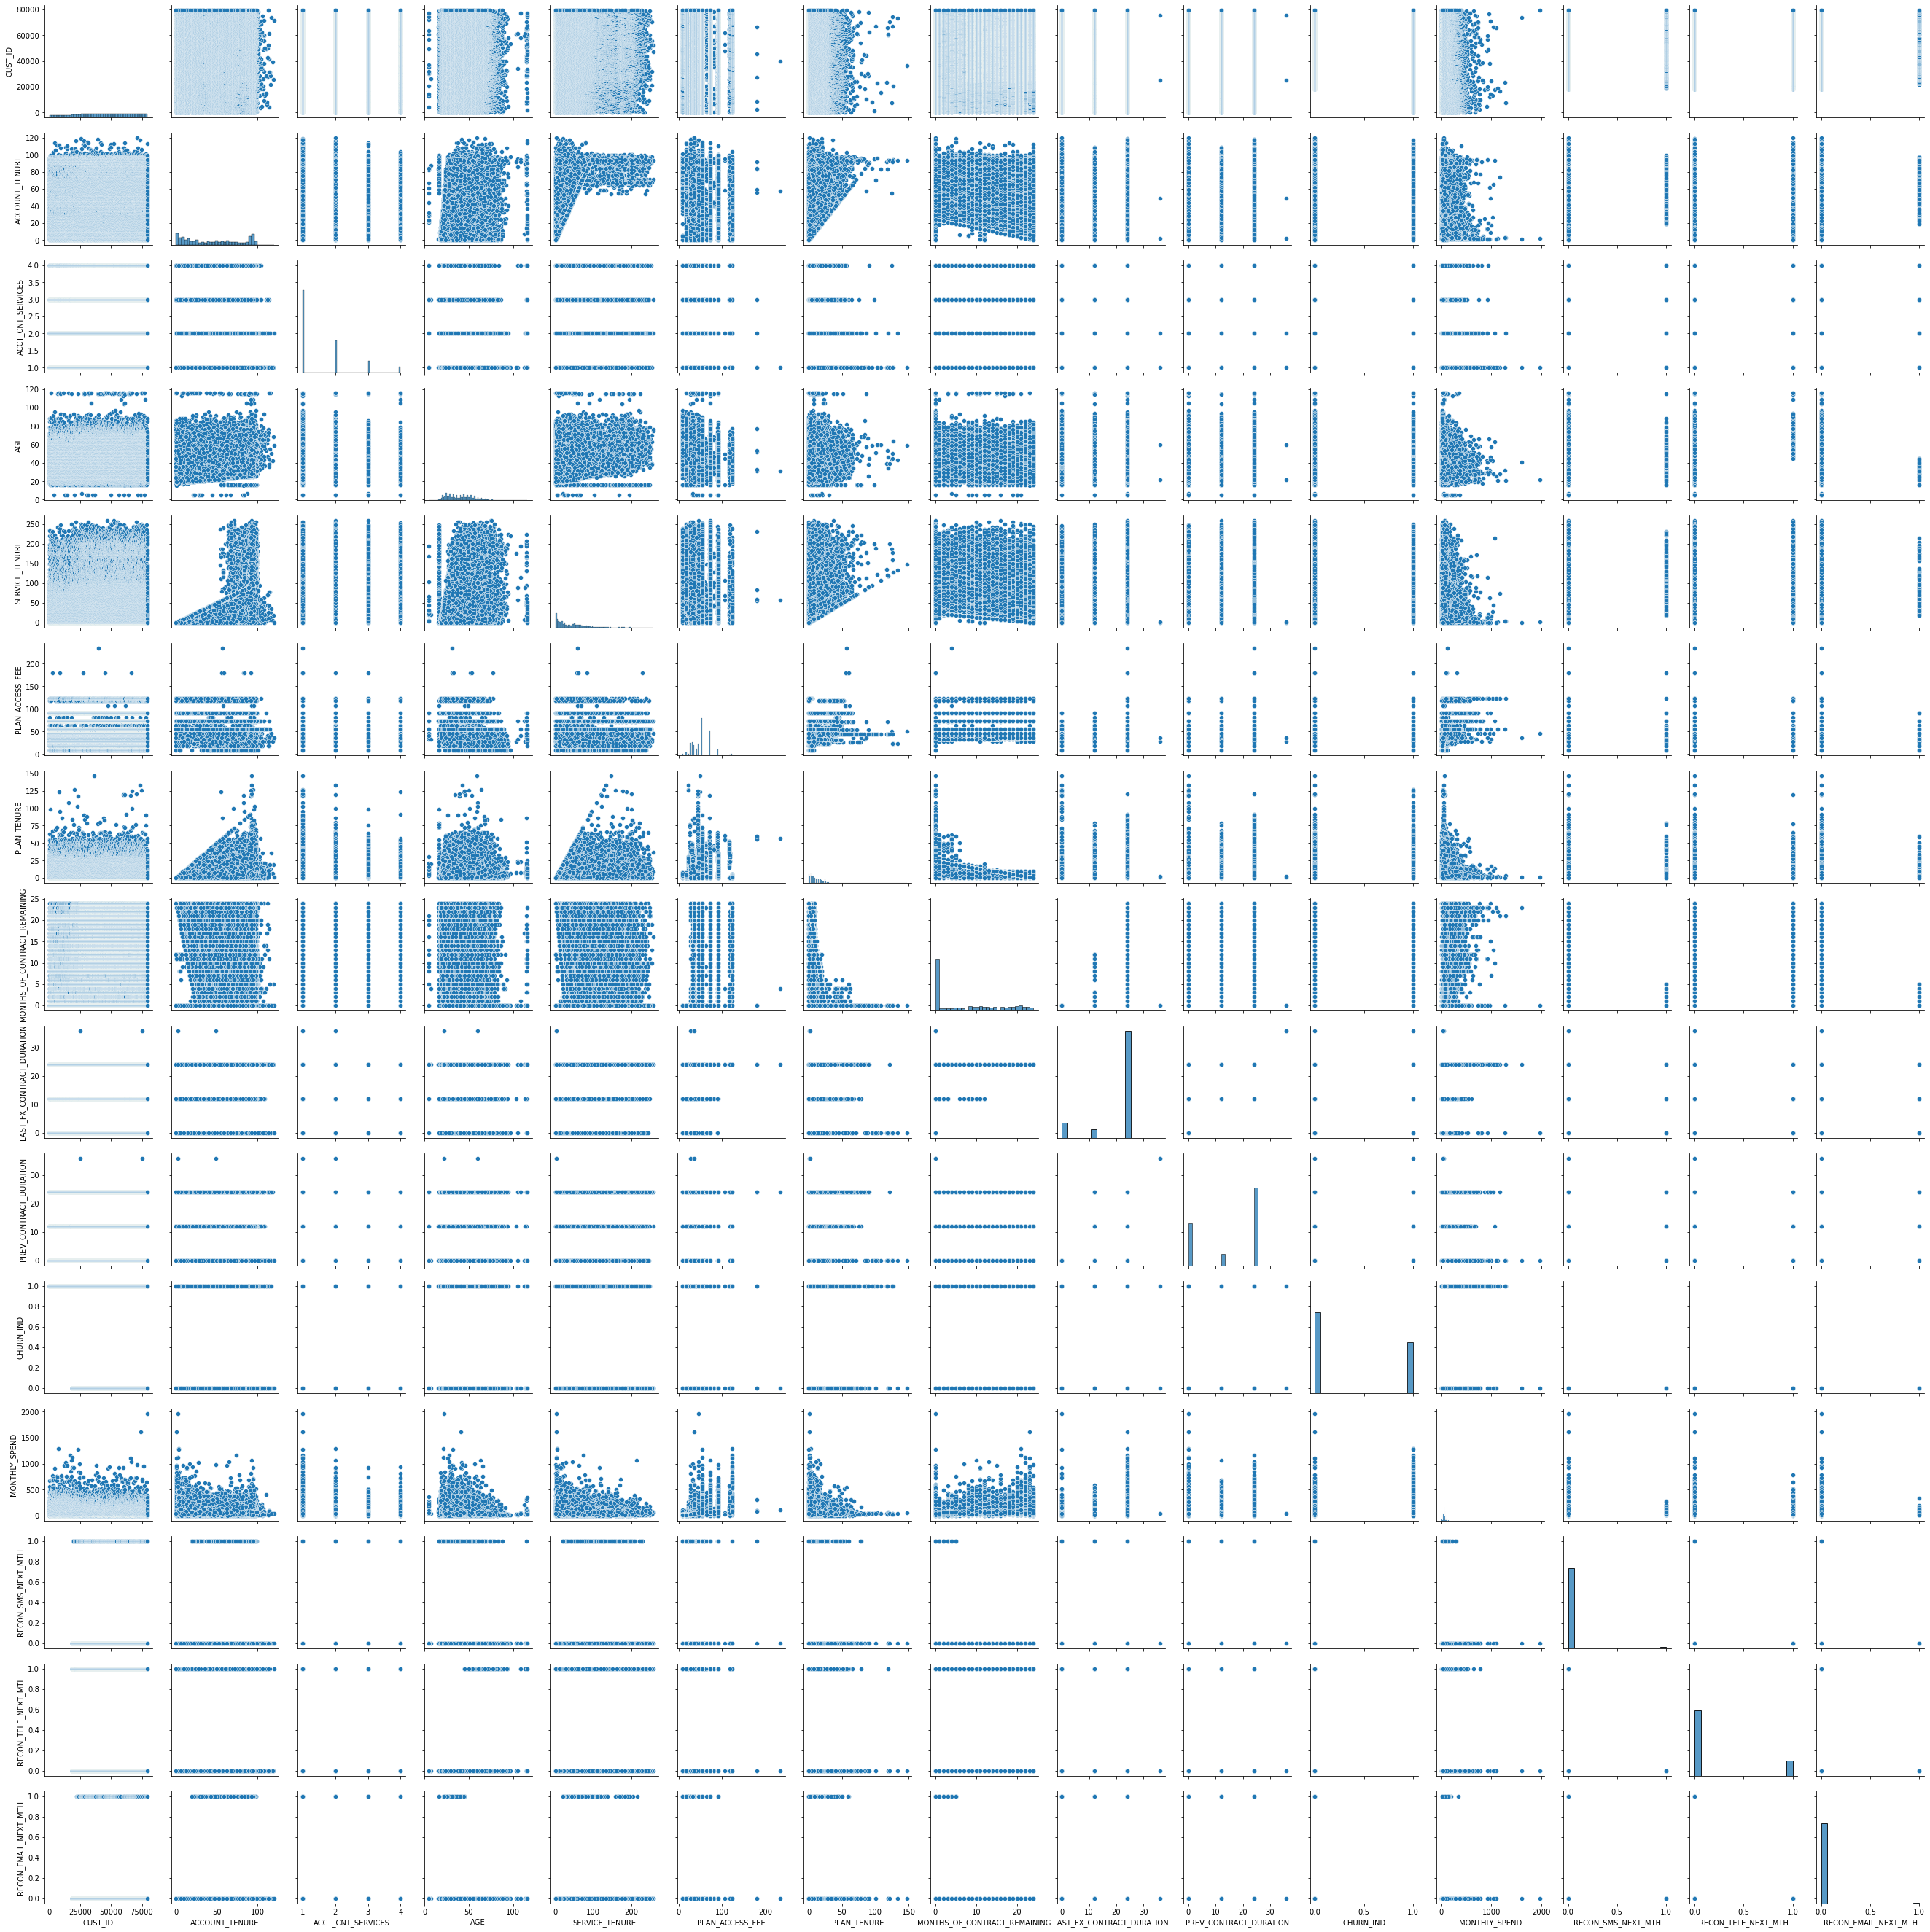

In [7]:
p = sns.pairplot(churn)
plt.rcParams["axes.labelsize"] = 20

## 4) Correlation

- Correlation matrix to get a view of the correlation relationship across the numerical variables
- There are some medium strength relationships between variables, the variables are: PLAN_TENURE, MONTHS_OF_CONTRACT_REMAINING, ACCOUNT_TENURE, AGE, SERVICE_TENURE, PLAN_ACCESS_FEE, LAST_FX_CONTRACT_DURATION, PREV_CONTRACT_DURATION, MONTHLY_SPEND

**Action:** Plot the correlation into a heatmap matrix for better visualisation

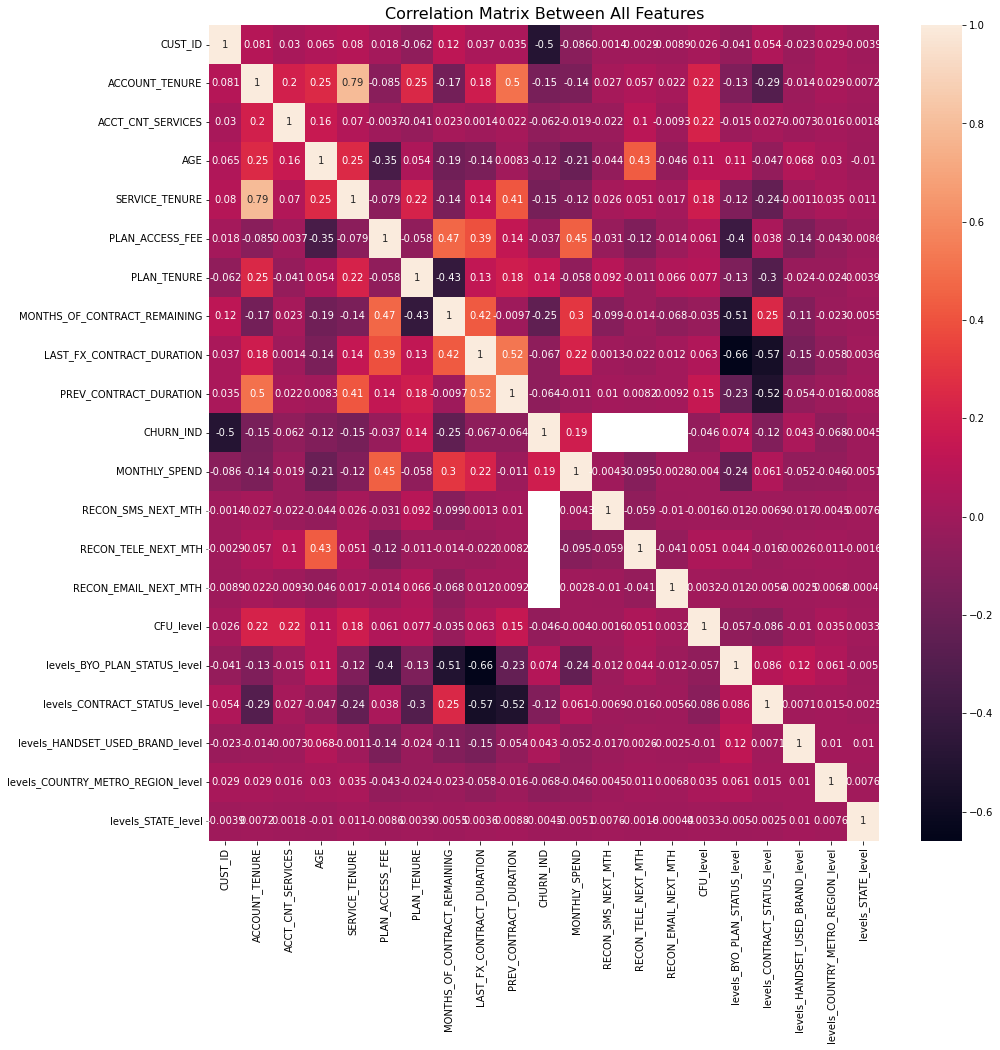

In [87]:
f = plt.figure(figsize=(15, 15))
sns.heatmap(churn.corr(), annot=True)
plt.title('Correlation Matrix Between All Features', fontsize=16);

## 5) Categorical Variables

- There are few categorical variables that need to be converted to numerical variables in order to be used in the clustering
- Categorical variables: CFU, BYO_PLAN_STATUS, CONTRACT_STATUS, HANDSET_USED_BRAND, COUNTRY_METRO_REGION, STATE

In [9]:
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


### 5.1) Convert CFU to numerical variable

**Action:** Check unique values

In [88]:
churn.CFU.unique()

array(['CONSUMER', 'SMALL BUSINESS'], dtype=object)

**Action:** Set categories and add as a new column

In [90]:
levels_cfu = pd.Categorical(churn.CFU, categories=['CONSUMER', 'SMALL BUSINESS'])
churn['CFU_level'] = levels_cfu.codes

**Action:** Verify new numerical variable

In [89]:
CFU_group = churn[['CFU','CFU_level']].groupby(['CFU']).mean()
CFU_group

,CFU_level
CFU,
CONSUMER,0.0
SMALL BUSINESS,1.0


### 5.2) Convert BYO_PLAN_STATUS to numerical variable

**Action:** Check unique values

In [91]:
churn.BYO_PLAN_STATUS.unique()

array(['NON BYO', 'BYO'], dtype=object)

**Action:** Set categories and add as a new column

In [13]:
levels_BYO_PLAN_STATUS = pd.Categorical(churn.BYO_PLAN_STATUS, categories=['NON BYO', 'BYO'])
churn['levels_BYO_PLAN_STATUS_level'] = levels_BYO_PLAN_STATUS.codes
# verify new numerical variable
BYO_PLAN_STATUS_group = churn[['BYO_PLAN_STATUS','levels_BYO_PLAN_STATUS_level']].groupby(['BYO_PLAN_STATUS']).mean()
BYO_PLAN_STATUS_group

,levels_BYO_PLAN_STATUS_level
BYO_PLAN_STATUS,
BYO,1.0
NON BYO,0.0


**Action:** Verify new numerical variable

In [92]:
BYO_PLAN_STATUS_group = churn[['BYO_PLAN_STATUS','levels_BYO_PLAN_STATUS_level']].groupby(['BYO_PLAN_STATUS']).mean()
BYO_PLAN_STATUS_group

,levels_BYO_PLAN_STATUS_level
BYO_PLAN_STATUS,
BYO,1.0
NON BYO,0.0


### 5.3) Convert CONTRACT_STATUS to numerical variable

**Action:** Check unique values

In [93]:
churn.CONTRACT_STATUS.unique()

array(['OFF-CONTRACT', 'ON-CONTRACT', 'NO-CONTRACT'], dtype=object)

**Action:** Set categories and add as a new column

In [95]:
levels_CONTRACT_STATUS = pd.Categorical(churn.CONTRACT_STATUS, categories=['OFF-CONTRACT', 'ON-CONTRACT', 'NO-CONTRACT'])
churn['levels_CONTRACT_STATUS_level'] = levels_CONTRACT_STATUS.codes

**Action:** Verify new numerical variable

In [94]:
CONTRACT_STATUS_group = churn[['CONTRACT_STATUS','levels_CONTRACT_STATUS_level']].groupby(['CONTRACT_STATUS']).mean()
CONTRACT_STATUS_group

,levels_CONTRACT_STATUS_level
CONTRACT_STATUS,
NO-CONTRACT,2.0
OFF-CONTRACT,0.0
ON-CONTRACT,1.0


### 5.4) Convert HANDSET_USED_BRAND to numerical variable

**Action:** Check unique values

In [96]:
churn.HANDSET_USED_BRAND.unique()

array(['SAMSUNG', 'APPLE', 'UNKNOWN', 'OTHER', 'GOOGLE', 'HUAWEI'],
      dtype=object)

**Action:** Set categories and add as a new column

In [17]:
levels_HANDSET_USED_BRAND = pd.Categorical(churn.HANDSET_USED_BRAND, categories=['SAMSUNG', 'APPLE', 'UNKNOWN', 'OTHER', 'GOOGLE', 'HUAWEI'])
churn['levels_HANDSET_USED_BRAND_level'] = levels_HANDSET_USED_BRAND.codes
# verify new numerical variable
HANDSET_USED_BRAND_group = churn[['HANDSET_USED_BRAND','levels_HANDSET_USED_BRAND_level']].groupby(['HANDSET_USED_BRAND']).mean()
HANDSET_USED_BRAND_group

,levels_HANDSET_USED_BRAND_level
HANDSET_USED_BRAND,
APPLE,1.0
GOOGLE,4.0
HUAWEI,5.0
OTHER,3.0
SAMSUNG,0.0
UNKNOWN,2.0


**Action:** Verify new numerical variable

In [97]:
HANDSET_USED_BRAND_group = churn[['HANDSET_USED_BRAND','levels_HANDSET_USED_BRAND_level']].groupby(['HANDSET_USED_BRAND']).mean()
HANDSET_USED_BRAND_group

,levels_HANDSET_USED_BRAND_level
HANDSET_USED_BRAND,
APPLE,1.0
GOOGLE,4.0
HUAWEI,5.0
OTHER,3.0
SAMSUNG,0.0
UNKNOWN,2.0


### 5.5) Convert COUNTRY_METRO_REGION to numerical variable

**Action:** Check unique values

In [98]:
churn.COUNTRY_METRO_REGION.unique()

array(['COUNTRY', 'METRO'], dtype=object)

**Action:** Remove rows where churn.COUNTRY_METRO_REGION value is not available

In [19]:
churn = churn.dropna(subset=['COUNTRY_METRO_REGION'])
churn = pd.DataFrame(churn)
churn.COUNTRY_METRO_REGION.unique()

array(['COUNTRY', 'METRO'], dtype=object)

**Action:** Set categories and add as a new column

In [20]:
levels_COUNTRY_METRO_REGION = pd.Categorical(churn.COUNTRY_METRO_REGION, categories=['COUNTRY', 'METRO'])
churn['levels_COUNTRY_METRO_REGION_level'] = levels_COUNTRY_METRO_REGION.codes
# verify new numerical variable
COUNTRY_METRO_REGION_group = churn[['COUNTRY_METRO_REGION','levels_COUNTRY_METRO_REGION_level']].groupby(['COUNTRY_METRO_REGION']).mean()
COUNTRY_METRO_REGION_group

,levels_COUNTRY_METRO_REGION_level
COUNTRY_METRO_REGION,
COUNTRY,0.0
METRO,1.0


**Action:** Verify new numerical variable

In [99]:
COUNTRY_METRO_REGION_group = churn[['COUNTRY_METRO_REGION','levels_COUNTRY_METRO_REGION_level']].groupby(['COUNTRY_METRO_REGION']).mean()
COUNTRY_METRO_REGION_group

,levels_COUNTRY_METRO_REGION_level
COUNTRY_METRO_REGION,
COUNTRY,0.0
METRO,1.0


### 5.6) Convert STATE to numerical variable

**Action:** Check unique values

In [100]:
churn.STATE.unique()

array(['WA', 'NSW', 'VIC', 'SA', 'QLD', 'TAS', 'ACT', 'NT'], dtype=object)

**Action:** Set categories and add as a new column

In [102]:
levels_STATE = pd.Categorical(churn.STATE, categories=['WA', 'NSW', 'VIC', 'SA', 'QLD', 'TAS', 'ACT', 'NT'])
churn['levels_STATE_level'] = levels_STATE.codes

**Action:** Verify new numerical variable

In [101]:
STATE_group = churn[['STATE','levels_STATE_level']].groupby(['STATE']).mean()
STATE_group

,levels_STATE_level
STATE,
ACT,6.0
NSW,1.0
NT,7.0
QLD,4.0
SA,3.0
TAS,5.0
VIC,2.0
WA,0.0


### 5.7) Numerical Dataframe
- Create new data frame with just numerical fields in the original dataframe
- Get a top-level descriptive summary of the new data frame and verify that the number of rows and columns are correct

In [56]:
churn_numeric = churn[['ACCOUNT_TENURE', 'ACCT_CNT_SERVICES', 'AGE', 'SERVICE_TENURE', 'PLAN_ACCESS_FEE', 'PLAN_TENURE', 'MONTHS_OF_CONTRACT_REMAINING', 'LAST_FX_CONTRACT_DURATION', 'PREV_CONTRACT_DURATION', 'CHURN_IND', 'MONTHLY_SPEND' , 'CFU_level' , 'levels_BYO_PLAN_STATUS_level', 'levels_CONTRACT_STATUS_level', 'levels_HANDSET_USED_BRAND_level', 'levels_COUNTRY_METRO_REGION_level', 'levels_STATE_level']]
churn_numeric.describe()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND,CFU_level,levels_BYO_PLAN_STATUS_level,levels_CONTRACT_STATUS_level,levels_HANDSET_USED_BRAND_level,levels_COUNTRY_METRO_REGION_level,levels_STATE_level
count,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000
mean,45.886856,1.554426,41.413576,50.364234,51.361234,10.850890,8.235090,20.351118,15.253192,0.385067,75.169090,0.152839,0.232337,0.848462,1.116266,0.688599,2.082338
std,33.073946,0.834363,15.261213,51.943989,20.854056,9.771842,8.339843,8.032833,10.981573,0.486616,73.393772,0.359836,0.422327,0.604130,1.198880,0.463071,1.412337
min,0.000000,1.000000,5.000000,0.000000,8.180000,0.000000,0.000000,0.000000,0.000000,0.000000,1.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,1.000000,28.000000,11.000000,36.360000,3.000000,0.000000,24.000000,0.000000,0.000000,36.360000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,44.000000,1.000000,40.000000,35.000000,54.540000,8.000000,7.000000,24.000000,24.000000,0.000000,54.540000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000
75%,77.000000,2.000000,52.000000,69.000000,72.720000,16.000000,16.000000,24.000000,24.000000,1.000000,84.530000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000
max,120.000000,4.000000,116.000000,259.000000,234.540000,147.000000,24.000000,36.000000,36.000000,1.000000,1965.890000,1.000000,1.000000,2.000000,5.000000,1.000000,7.000000


In [103]:
churn_numeric.shape

(46127, 17)

Cleaned dataframe still has a significant number of rows, and all numerical variables have correct and positive values. Dataframe is now ready for modeling.

## 6) Clustering

- Since we don't know how many clusters there should be in the data, it is recommended to use Hierarchical clustering and examine the dendograph to understand what natural clusters are present in the data.

#### 6.1) Create two groups based on Churn status

- As Churn status is a major variable that separates customer types, it is recommended to separate into two groups based on Churn status in order to better identify clusters within each group

In [58]:
churn_numeric['CHURN_IND'].unique()

array([1, 0], dtype=int64)

CHURN_IND = 1 for customer that churned, and CHURN_IND = 0 for customer that did not churn

In [26]:
# Create Group where customer Churned
churn_numeric_churned = churn_numeric[churn_numeric['CHURN_IND'] == 0]
print('Shape of churned customer table:', churn_numeric_churned.shape)

Shape of churned customer table: (28365, 17)


In [27]:
# Create Group where customer did not churn
churn_numeric_non_churn = churn_numeric[churn_numeric['CHURN_IND'] == 1]
print('Shape of non-churn customer table:', churn_numeric_non_churn.shape)

Shape of non-churn customer table: (17762, 17)


#### 6.2) Normalize the data

**Action:** For Total Group (all customers) - Normalize the dataframe by subtracting the mean, divide by the standard deviation

In [104]:
churn_numeric_norm = (churn_numeric-churn_numeric.mean())/churn_numeric.std()
churn_numeric_norm.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND,CFU_level,levels_BYO_PLAN_STATUS_level,levels_CONTRACT_STATUS_level,levels_HANDSET_USED_BRAND_level,levels_COUNTRY_METRO_REGION_level,levels_STATE_level
INDEX,,,,,,,,,,,,,,,,,
1,0.003421,-0.664490,-0.747881,-0.084018,0.152429,0.424599,-0.987439,0.454246,0.796499,1.263691,-0.187606,-0.424746,-0.550135,-1.404436,-0.931091,-1.487025,-1.474392
2,0.426715,1.732549,0.890258,0.166252,0.152429,-0.598750,-0.987439,0.454246,0.796499,1.263691,-0.281074,-0.424746,-0.550135,-1.404436,-0.096979,0.672469,-0.766346
3,0.577891,-0.664490,-0.813407,0.281761,-0.501640,0.424599,-0.987439,-1.039623,-0.296241,1.263691,-0.990126,-0.424746,1.817698,-1.404436,-0.096979,-1.487025,-1.474392
4,-0.450108,-0.664490,0.628156,-0.372791,-0.937527,2.061956,-0.987439,0.454246,0.796499,1.263691,-0.935898,-0.424746,-0.550135,-1.404436,-0.096979,-1.487025,-0.058299
5,1.484950,-0.664490,-0.682356,0.859306,0.152429,-1.110424,-0.987439,0.454246,0.796499,1.263691,0.341322,-0.424746,-0.550135,-1.404436,-0.096979,0.672469,-0.766346


**Action:** For Churned group (churned customers) - Normalize the dataframe by subtracting the mean, divide by the standard deviation

In [105]:
churn_numeric_churned_norm = (churn_numeric_churned-churn_numeric_churned.mean())/churn_numeric_churned.std()
churn_numeric_churned_norm.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND,CFU_level,levels_BYO_PLAN_STATUS_level,levels_CONTRACT_STATUS_level,levels_HANDSET_USED_BRAND_level,levels_COUNTRY_METRO_REGION_level,levels_STATE_level
INDEX,,,,,,,,,,,,,,,,,
8153,-1.048884,-0.691299,1.525132,-0.758175,-0.944501,0.597470,-0.103894,0.425306,-1.470251,NaN,0.212059,-0.445928,-0.511918,0.175929,-0.063799,-1.578831,-1.48512
8155,-0.025878,0.469391,0.801844,-0.139808,-0.305789,2.192213,-1.181915,0.425306,0.761623,NaN,0.541326,-0.445928,-0.511918,-1.686099,-0.913411,0.633358,-0.77365
8159,0.636066,0.469391,-0.578978,-0.103434,0.972573,2.192213,-1.181915,0.425306,0.761623,NaN,2.067519,-0.445928,-0.511918,-1.686099,-0.913411,-1.578831,-0.77365
8169,-1.229414,-0.691299,-1.039252,-0.867298,0.972573,-0.085992,0.614787,0.425306,0.761623,NaN,-0.013072,2.242435,-0.511918,0.175929,-0.913411,0.633358,-0.06218
8172,-0.116143,-0.691299,-0.578978,-0.194370,0.972573,-0.313812,0.854347,0.425306,0.761623,NaN,0.433135,-0.445928,-0.511918,0.175929,-0.063799,0.633358,-0.06218


Remove 'CHURN_IND' column since it is known that every row is a churned customer, in order to have finite values across all columns.

**Action:** For Total Group

In [106]:
churn_numeric_total_norm = churn_numeric_norm.drop(['CHURN_IND'], axis=1)
churn_numeric_total_norm.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,MONTHLY_SPEND,CFU_level,levels_BYO_PLAN_STATUS_level,levels_CONTRACT_STATUS_level,levels_HANDSET_USED_BRAND_level,levels_COUNTRY_METRO_REGION_level,levels_STATE_level
INDEX,,,,,,,,,,,,,,,,
1,0.003421,-0.664490,-0.747881,-0.084018,0.152429,0.424599,-0.987439,0.454246,0.796499,-0.187606,-0.424746,-0.550135,-1.404436,-0.931091,-1.487025,-1.474392
2,0.426715,1.732549,0.890258,0.166252,0.152429,-0.598750,-0.987439,0.454246,0.796499,-0.281074,-0.424746,-0.550135,-1.404436,-0.096979,0.672469,-0.766346
3,0.577891,-0.664490,-0.813407,0.281761,-0.501640,0.424599,-0.987439,-1.039623,-0.296241,-0.990126,-0.424746,1.817698,-1.404436,-0.096979,-1.487025,-1.474392
4,-0.450108,-0.664490,0.628156,-0.372791,-0.937527,2.061956,-0.987439,0.454246,0.796499,-0.935898,-0.424746,-0.550135,-1.404436,-0.096979,-1.487025,-0.058299
5,1.484950,-0.664490,-0.682356,0.859306,0.152429,-1.110424,-0.987439,0.454246,0.796499,0.341322,-0.424746,-0.550135,-1.404436,-0.096979,0.672469,-0.766346


**Action:** For Churned Group

In [107]:
churn_numeric_churned_norm = churn_numeric_churned_norm.drop(['CHURN_IND'], axis=1)
churn_numeric_churned_norm.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,MONTHLY_SPEND,CFU_level,levels_BYO_PLAN_STATUS_level,levels_CONTRACT_STATUS_level,levels_HANDSET_USED_BRAND_level,levels_COUNTRY_METRO_REGION_level,levels_STATE_level
INDEX,,,,,,,,,,,,,,,,
8153,-1.048884,-0.691299,1.525132,-0.758175,-0.944501,0.597470,-0.103894,0.425306,-1.470251,0.212059,-0.445928,-0.511918,0.175929,-0.063799,-1.578831,-1.48512
8155,-0.025878,0.469391,0.801844,-0.139808,-0.305789,2.192213,-1.181915,0.425306,0.761623,0.541326,-0.445928,-0.511918,-1.686099,-0.913411,0.633358,-0.77365
8159,0.636066,0.469391,-0.578978,-0.103434,0.972573,2.192213,-1.181915,0.425306,0.761623,2.067519,-0.445928,-0.511918,-1.686099,-0.913411,-1.578831,-0.77365
8169,-1.229414,-0.691299,-1.039252,-0.867298,0.972573,-0.085992,0.614787,0.425306,0.761623,-0.013072,2.242435,-0.511918,0.175929,-0.913411,0.633358,-0.06218
8172,-0.116143,-0.691299,-0.578978,-0.194370,0.972573,-0.313812,0.854347,0.425306,0.761623,0.433135,-0.445928,-0.511918,0.175929,-0.063799,0.633358,-0.06218


#### 6.3) Elbow method to determine number of clusters

**Action:** Run K-Means for a range of clusters using a for loop and collecting the distortions into a list

In [119]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(churn_numeric_total_norm)
    distortions.append(kmeanModel.inertia_)

**Action:** Plotting the distortions of K-Means to observe for the "elbow"

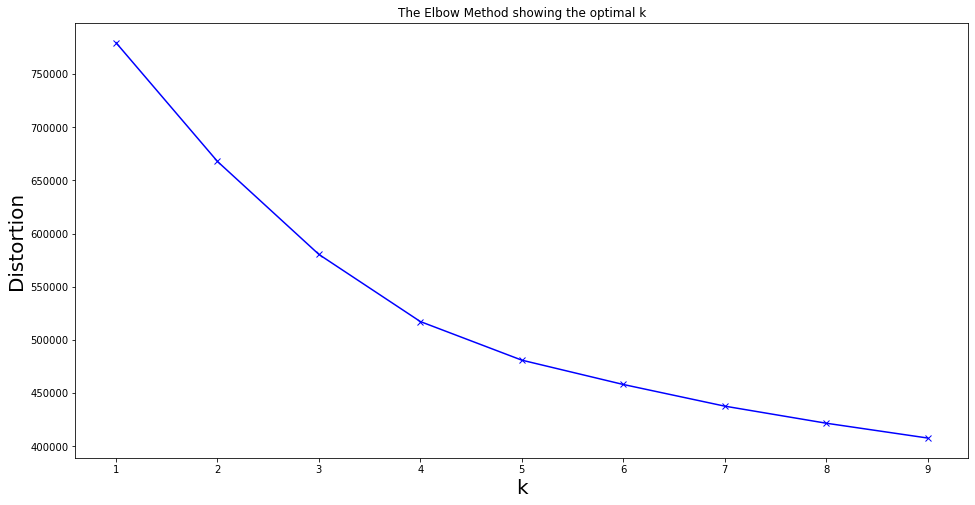

In [120]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We can observe that the “elbow” is the number 5, which is the point of inflection on the curve and thus is optimal for this dataset

#### 6.4) Hierarchical clustering and examine the dendograph to observe for clusters

**Action:** Calculate the distance between clusters for Total Group

In [108]:
dist = pdist(churn_numeric_total_norm, 'euclidean')
linkage_matrix_total = linkage(dist,method = 'ward')

**Action:** Calculate the distance between clusters for Churned Group

In [35]:
dist = pdist(churn_numeric_churned_norm, 'euclidean')
linkage_matrix_churned = linkage(dist,method = 'ward')

#### 6.5) Dendrogram to visualize clusters

**Action:** For Total Group

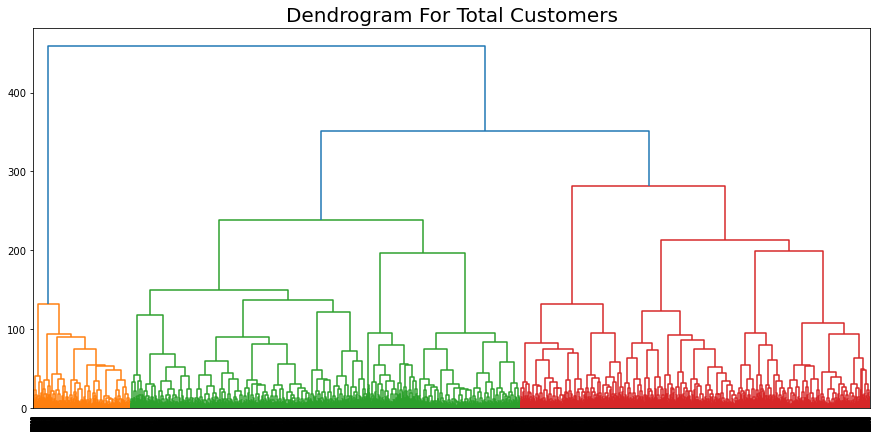

In [82]:
# TOTAL
plt.figure(figsize=(15,7))
plt.title('Dendrogram For Total Customers', fontsize=20)
dendrogram(linkage_matrix_total)
plt.show()

**Action:** For Churned Group

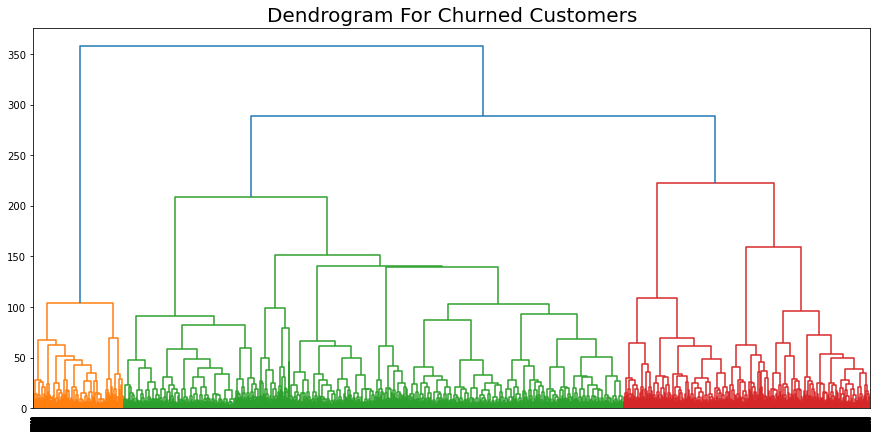

In [83]:
# CHURNED
plt.figure(figsize=(15,7))
plt.title('Dendrogram For Churned Customers', fontsize=20)
dendrogram(linkage_matrix_churned)
plt.show()

#### 6.6) Number of clusters for cluster analysis

- Both dendrograms for Total Customers and Churned Customer are rather identical, indicating that cluster charisteristics is most likely to be similar across both types. 

- When a line is drawn on 220 of the Total Customers dendrogram, it shows 5 clusters. Since this is consistent with the 5 clusters observed in the "Elbow" method we will proceed to create a model based on 5 clusters. 

#### 6.7) Get a fixed number of clusters using the cut_tree function

**Action:** For Total Group

In [130]:
labels_norm_total = cut_tree(linkage_matrix_total, n_clusters=5)
churn_numeric_total_norm['labels_norm_total'] = labels_norm_total

**Action:** For Churned Group

In [135]:
labels_norm_churned = cut_tree(linkage_matrix_churned, n_clusters=5)
churn_numeric_churned_norm['labels_norm_churned'] = labels_norm_churned

#### 6.8) Group by cluster and get average value for all columns

**Action:** For Total Group

In [131]:
churn_numeric_norm_mean = churn_numeric_total_norm[['labels_norm_total','ACCOUNT_TENURE', 'ACCT_CNT_SERVICES', 'AGE', 'SERVICE_TENURE', 'PLAN_ACCESS_FEE', 'PLAN_TENURE', 'MONTHS_OF_CONTRACT_REMAINING', 'LAST_FX_CONTRACT_DURATION', 'PREV_CONTRACT_DURATION', 'MONTHLY_SPEND' , 'CFU_level' , 'levels_BYO_PLAN_STATUS_level', 'levels_CONTRACT_STATUS_level', 'levels_HANDSET_USED_BRAND_level', 'levels_COUNTRY_METRO_REGION_level', 'levels_STATE_level']].groupby(['labels_norm_total']).mean()
churn_numeric_norm_mean

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,MONTHLY_SPEND,CFU_level,levels_BYO_PLAN_STATUS_level,levels_CONTRACT_STATUS_level,levels_HANDSET_USED_BRAND_level,levels_COUNTRY_METRO_REGION_level,levels_STATE_level
labels_norm_total,,,,,,,,,,,,,,,,
0,0.243097,-0.142476,0.167524,0.199955,-0.419508,0.364042,-0.670231,0.148043,0.436095,-0.285994,-0.314224,0.345599,-0.989183,0.502157,-0.057454,0.005855
1,-0.849555,-0.227485,-0.351267,-0.663588,0.375139,-0.197202,0.697939,0.450336,-1.022134,0.896861,-0.343087,-0.545909,0.227601,-0.311907,-0.093861,-0.014078
2,0.289734,0.081555,-0.181408,0.201825,0.479976,-0.194725,0.674084,0.454132,0.567757,-0.014970,-0.401970,-0.550135,0.248175,-0.339239,0.029715,0.003308
3,-0.592658,-0.018843,0.285737,-0.466271,-0.886401,-0.377819,-0.987083,-2.532383,-1.388981,-0.529579,-0.199822,1.520125,1.904881,0.341522,0.134500,-0.011508
4,0.568829,0.503046,0.264017,0.479461,0.181774,0.227329,-0.046578,0.335519,0.480606,-0.107363,2.352356,-0.192375,-0.350844,-0.278517,0.079504,0.010094


**Action:** For Churned Group

In [136]:
churn_numeric_churned_norm_mean = churn_numeric_churned_norm[['labels_norm_churned','ACCOUNT_TENURE', 'ACCT_CNT_SERVICES', 'AGE', 'SERVICE_TENURE', 'PLAN_ACCESS_FEE', 'PLAN_TENURE', 'MONTHS_OF_CONTRACT_REMAINING', 'LAST_FX_CONTRACT_DURATION', 'PREV_CONTRACT_DURATION', 'MONTHLY_SPEND' , 'CFU_level' , 'levels_BYO_PLAN_STATUS_level', 'levels_CONTRACT_STATUS_level', 'levels_HANDSET_USED_BRAND_level', 'levels_COUNTRY_METRO_REGION_level', 'levels_STATE_level']].groupby(['labels_norm_churned']).mean()
churn_numeric_churned_norm_mean

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,MONTHLY_SPEND,CFU_level,levels_BYO_PLAN_STATUS_level,levels_CONTRACT_STATUS_level,levels_HANDSET_USED_BRAND_level,levels_COUNTRY_METRO_REGION_level,levels_STATE_level
labels_norm_churned,,,,,,,,,,,,,,,,
0,-0.997705,-0.062581,-0.216190,-0.830227,0.163174,-0.124693,0.563872,0.422191,-1.424598,0.043825,-0.225966,-0.511918,0.175929,-0.349853,-0.041769,-0.017820
1,0.415623,-0.132143,0.369309,0.392066,-0.699585,0.575534,-1.167170,-0.031543,0.451731,-0.436164,-0.252420,0.833112,-1.620833,0.214500,0.040271,-0.010523
2,0.576907,0.517453,0.215638,0.488677,0.109973,0.011008,0.011432,0.299181,0.580558,-0.022754,2.241678,-0.098722,-0.264663,-0.025268,0.046972,0.004758
3,0.208380,-0.059671,-0.204281,0.137560,0.398098,-0.100616,0.512234,0.423899,0.539049,0.303240,-0.404849,-0.508729,0.164940,-0.046971,-0.035539,0.013805
4,-0.667439,-0.058230,0.317761,-0.493344,-0.878402,-0.318987,-1.090078,-2.622954,-1.421732,-0.577481,-0.229603,1.619012,1.902625,0.402908,0.087847,-0.018088


Create a column to identify the cluster number, so we can use that column to differentiate between clusters

**Action:** For Total Group

In [132]:
churn_numeric_norm_mean['labels_norm_total'] = churn_numeric_norm_mean.index
churn_numeric_norm_mean.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,MONTHLY_SPEND,CFU_level,levels_BYO_PLAN_STATUS_level,levels_CONTRACT_STATUS_level,levels_HANDSET_USED_BRAND_level,levels_COUNTRY_METRO_REGION_level,levels_STATE_level,labels_norm_total
labels_norm_total,,,,,,,,,,,,,,,,,
0,0.243097,-0.142476,0.167524,0.199955,-0.419508,0.364042,-0.670231,0.148043,0.436095,-0.285994,-0.314224,0.345599,-0.989183,0.502157,-0.057454,0.005855,0
1,-0.849555,-0.227485,-0.351267,-0.663588,0.375139,-0.197202,0.697939,0.450336,-1.022134,0.896861,-0.343087,-0.545909,0.227601,-0.311907,-0.093861,-0.014078,1
2,0.289734,0.081555,-0.181408,0.201825,0.479976,-0.194725,0.674084,0.454132,0.567757,-0.014970,-0.401970,-0.550135,0.248175,-0.339239,0.029715,0.003308,2
3,-0.592658,-0.018843,0.285737,-0.466271,-0.886401,-0.377819,-0.987083,-2.532383,-1.388981,-0.529579,-0.199822,1.520125,1.904881,0.341522,0.134500,-0.011508,3
4,0.568829,0.503046,0.264017,0.479461,0.181774,0.227329,-0.046578,0.335519,0.480606,-0.107363,2.352356,-0.192375,-0.350844,-0.278517,0.079504,0.010094,4


**Action:** For Churned Group

In [137]:
churn_numeric_churned_norm_mean['labels_norm_churned'] = churn_numeric_churned_norm_mean.index
churn_numeric_churned_norm_mean.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,MONTHLY_SPEND,CFU_level,levels_BYO_PLAN_STATUS_level,levels_CONTRACT_STATUS_level,levels_HANDSET_USED_BRAND_level,levels_COUNTRY_METRO_REGION_level,levels_STATE_level,labels_norm_churned
labels_norm_churned,,,,,,,,,,,,,,,,,
0,-0.997705,-0.062581,-0.216190,-0.830227,0.163174,-0.124693,0.563872,0.422191,-1.424598,0.043825,-0.225966,-0.511918,0.175929,-0.349853,-0.041769,-0.017820,0
1,0.415623,-0.132143,0.369309,0.392066,-0.699585,0.575534,-1.167170,-0.031543,0.451731,-0.436164,-0.252420,0.833112,-1.620833,0.214500,0.040271,-0.010523,1
2,0.576907,0.517453,0.215638,0.488677,0.109973,0.011008,0.011432,0.299181,0.580558,-0.022754,2.241678,-0.098722,-0.264663,-0.025268,0.046972,0.004758,2
3,0.208380,-0.059671,-0.204281,0.137560,0.398098,-0.100616,0.512234,0.423899,0.539049,0.303240,-0.404849,-0.508729,0.164940,-0.046971,-0.035539,0.013805,3
4,-0.667439,-0.058230,0.317761,-0.493344,-0.878402,-0.318987,-1.090078,-2.622954,-1.421732,-0.577481,-0.229603,1.619012,1.902625,0.402908,0.087847,-0.018088,4


#### 6.9) Plot a chart to visualize the difference in column averages, grouped by Cluster number

- Swarmplot was used to visualize the average of each columns, grouped by Cluster number being the hue

Dataframe was melted in order for Swarmplot to show each column as an X index

**Action:** For Total Group

In [133]:
melted_df_total = pd.melt(churn_numeric_norm_mean,
                    id_vars=['ACCOUNT_TENURE','ACCT_CNT_SERVICES', 'labels_norm_total'],  # variables to keep 
                    var_name="Stat") # name of melted variable

**Action:** For Churned Group

In [138]:
melted_df_churned = pd.melt(churn_numeric_churned_norm_mean,
                    id_vars=['ACCOUNT_TENURE','ACCT_CNT_SERVICES', 'labels_norm_churned'],  # variables to keep 
                    var_name="Stat") # name of melted variable

**Action:** Plot graph for Total Group

<AxesSubplot:title={'center':'Average Column Values Across Total Customers'}, xlabel='Stat', ylabel='value'>

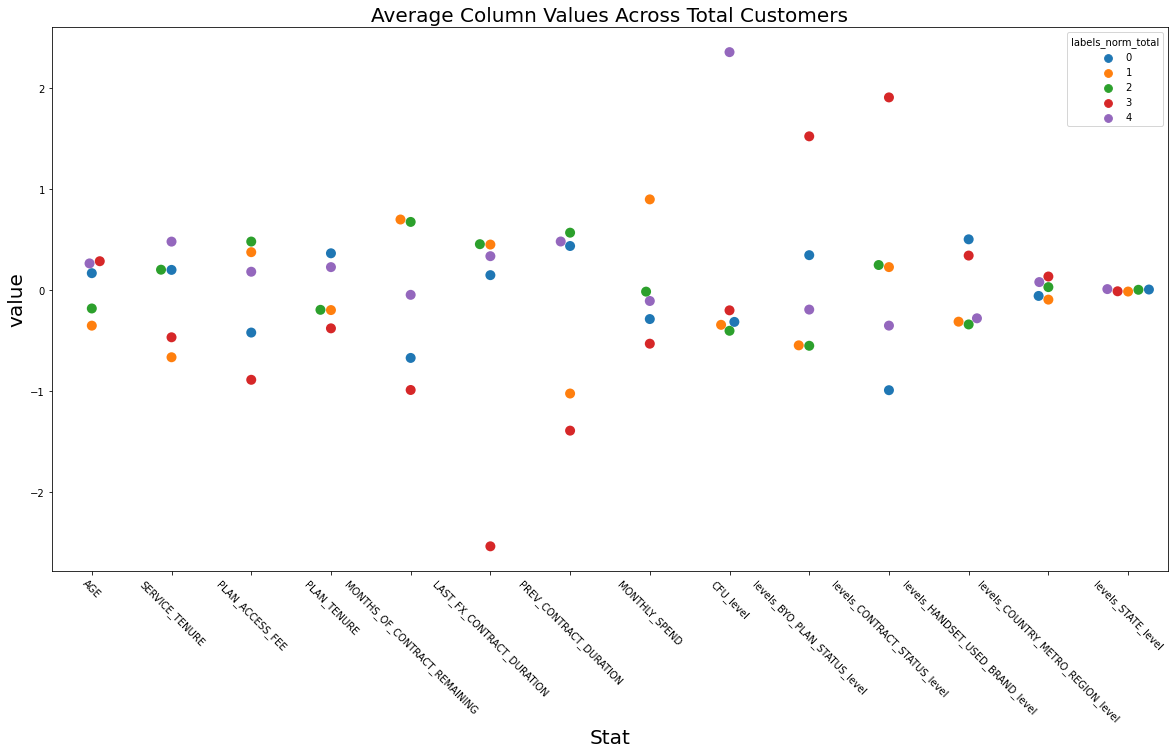

In [134]:
plt.figure(figsize=(20,10))
plt.title('Average Column Values Across Total Customers', fontsize=20)
plt.xticks(rotation=-45) # rotate x-labels

# plot swarmplot with melted_df
sns.swarmplot(x='Stat',
              y='value',
              data=melted_df_total,
              hue='labels_norm_total', 
              dodge=False, # separate points by hue
              s=10) # reduce size of each spot to remove rendering error

#### 6.10) Cluster Characteristics - Total Customers

1. Cluster 1 (Orange): They tend to have certain attributes that are highest or longest compared to the other clusters - like plan access fee, months of contract remaining, last fx contract duration and monthly spend. Indicating that these are the highest customer lifetime value consumer customers, who are generally on higher value and longer term plans. 

2. Cluster 2 (Green): They tend to have rather high attributes for plan access fee, months of contract remaining, last fx contract duration, previous contract duration. And are generally have handset with their service plan. Indicating that this cluster are medium-high customer lifetime valye consumer customers, who generally get on longer-term plan with a device and tend to stick with the telecommunications company.

3. Cluster 4 (Purple): They have the highest attributes for service tenure and CFU level. Indicating that this cluster are generally small business customers, who tend to be on longer term services with the telecommunications company. They generally stick to the same telecommunications provider for their business operations.

4. Cluster 3 (Red): They tend to have certain attributes that are the lowest compared to the other clusters - like service tenure, plan access fee, plan tenure, months of contract remaining, last fx contract duration, previous contract duration and monthly spend. They are also mainly on no-contract BYO plans that do no include handsets and the plan is not contract based. Indicating that this cluster are generally more short-term and value-for-money consumers, who are most probably on prepaid mobile plans that are lower cost and short-termed, and using their own handsets that is not necessary purchased from this telecommuncations company. And has a higher chance of switching to another provider to access more value-for-money prepaid plans. 

5. Cluster 0 (Blue): They are generally in the middle level in terms of most attributes, however many of them are off contract. Indicating that these are the most general consumer customer types, in the middle in terms of plan value and service term with the telecommunications company and are ought to be targeted for a new contract to keep them as active customers.

**Action:** Plot graph for Churned Group

<AxesSubplot:title={'center':'Average Column Values Across Churned Customers'}, xlabel='Stat', ylabel='value'>

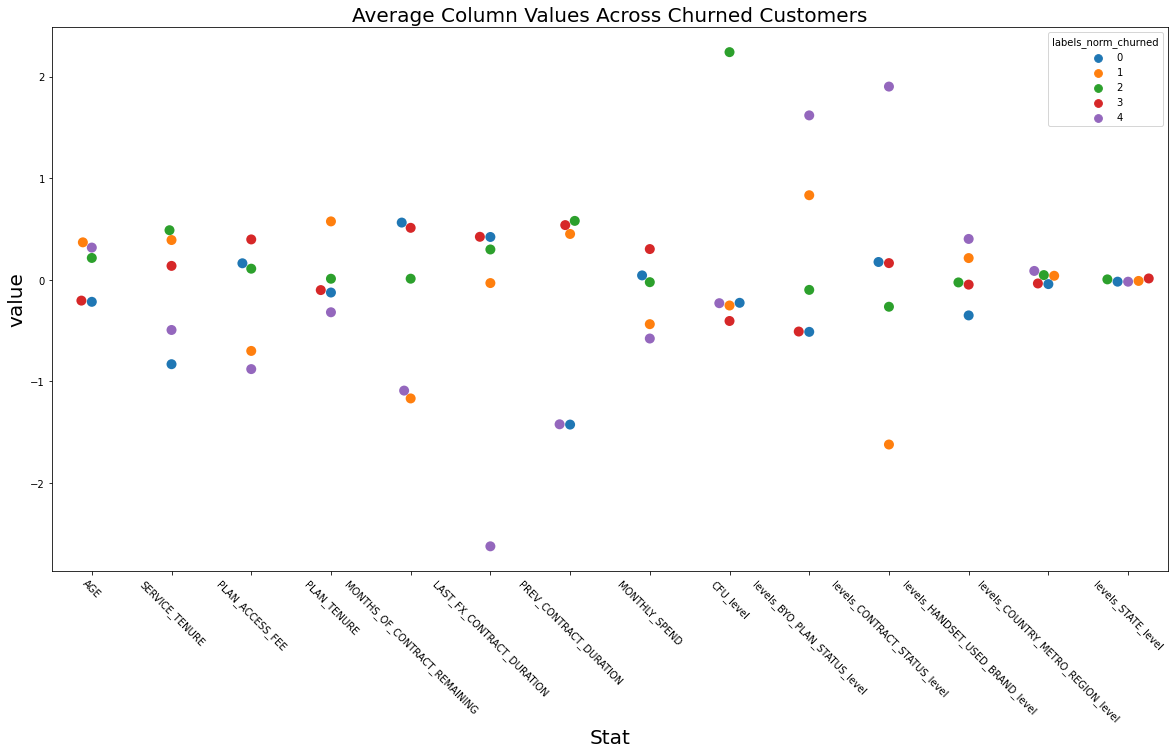

In [139]:
plt.figure(figsize=(20,10))
plt.title('Average Column Values Across Churned Customers', fontsize=20)
plt.xticks(rotation=-45) # rotate x-labels

# plot swarmplot with melted_df
sns.swarmplot(x='Stat',
              y='value',
              data=melted_df_churned,
              hue='labels_norm_churned', 
              dodge=False, # separate points by hue
              s=10) # reduce size of each spot to remove rendering error

#### 6.11) Cluster Characteristics - Churned Customers

- The swarmplots show that the average attribute values among clusters for Churned Customer is almost identical to Total Customers, indicating that the cluster characteristics are the same for both Churned and Total Customers.
- Hence the same cluster charateristics for Total Customers from Section 6.10 would also apply for Churned customers.

## 7) Predictive Modeling

- Build and evaluate a predictive model for churn - predict the value of the CHURN_IND field in the data from some of the other fields

### 7A.1) Model A

- We will first run a linear regression with a single input variable: MONTHS_OF_CONTRACT_REMAINING

#### 7A.2) Define the variables

In [60]:
churn_a_X = churn_numeric_norm[['MONTHS_OF_CONTRACT_REMAINING']]
churn_a_y = churn_numeric_norm[['CHURN_IND']]

#### 7A.3) Create Train and Test segments

- Set test segment to be 20% of total data
- Shape for both segments verified (36901 rows for training data, 9226 rows for test data)

In [61]:
from sklearn.model_selection import train_test_split

churn_a_X_train, churn_a_X_test, churn_a_y_train, churn_a_y_test = train_test_split(churn_a_X, churn_a_y, test_size=0.2)
print('Model A training data shape:', churn_a_X_train.shape)
print('Model A test data shape:', churn_a_X_test.shape)

Model A training data shape: (36901, 1)
Model A test data shape: (9226, 1)


#### 7A.4) Train the model

- Run the linear regression on the training data
- Based on the model, every one unit of change in 'MONTHS_OF_CONTRACT_REMAINING', the change in 'CHURN_IND' is about -25%

In [62]:
reg = linear_model.LinearRegression()
reg.fit(churn_a_X_train, churn_a_y_train) 
print("y = x *", reg.coef_, "+", reg.intercept_)

y = x * [[-0.24554653]] + [-0.00367552]


#### 7A.5) Make some predictions on test data

In [63]:
y_pred_a = reg.predict(churn_a_X_test)

#### 7A.6) Evaluate the performance of the model A

- Model A - uses 1 input variable ('MONTHS_OF_CONTRACT_REMAINING') to predict the value of 'CHURN_IND'
- MSE and R Squared of Model A are evaluated below

In [64]:
predicted_a = reg.predict(churn_a_X_test)
mse_a = ((np.array(churn_a_y_test)-predicted_a)**2).sum()/len(churn_a_y_test)
r2_a = r2_score(churn_a_y_test, predicted_a)
print("MSE of Model A:", mse_a)
print("R Squared of Model A:", r2_a)

MSE of Model A: 0.943413611063411
R Squared of Model A: 0.063271506657672


### 7B.1) Model B

- We will now run a linear regression with 4 input variables: MONTHS_OF_CONTRACT_REMAINING, PLAN_ACCESS_FEE, PLAN_TENURE, PREV_CONTRACT_DURATION

#### 7B.2) Define the variables

In [65]:
churn_b_X = churn_numeric_norm[['MONTHS_OF_CONTRACT_REMAINING', 'PLAN_ACCESS_FEE', 'PLAN_TENURE', 'PREV_CONTRACT_DURATION']]
churn_b_y = churn_numeric_norm[['CHURN_IND']]

#### 7B.3) Create Train and Test segments

- Set test segment to be 20% of total data
- Shape for both segments verified (36901 rows for training data, 9226 rows for test data)

In [66]:
churn_b_X_train, churn_b_X_test, churn_b_y_train, churn_b_y_test = train_test_split(churn_b_X, churn_b_y, test_size=0.2)
print('Model B training data shape:', churn_b_X_train.shape)
print('Model B test data shape:', churn_b_X_test.shape)

Model B training data shape: (36901, 4)
Model B test data shape: (9226, 4)


#### 7B.4) Train the model

- Run the linear regression on the training data
- Based on the model for every one unit of change in 'MONTHS_OF_CONTRACT_REMAINING', the change in 'CHURN_IND' is about -28%
- Based on the model for every one unit of change in 'PLAN_ACCESS_FEE', the change in 'CHURN_IND' is about 10%
- Based on the model for every one unit of change in 'PLAN_TENURE', the change in 'CHURN_IND' is about 4%
- Based on the model for every one unit of change in 'PREV_CONTRACT_DURATION', the change in 'CHURN_IND' is about -9%

In [67]:
reg = linear_model.LinearRegression()
reg.fit(churn_b_X_train, churn_b_y_train) 
print("y = x *", reg.coef_, "+", reg.intercept_)

y = x * [[-0.28293475  0.10519332  0.03991902 -0.0912881 ]] + [-0.00331234]


#### 7B.5) Make some predictions on test data

In [68]:
y_pred_b = reg.predict(churn_b_X_test)

#### 7B.6) Evaluate the performance of the model A

- Model B - uses 4 input variables (MONTHS_OF_CONTRACT_REMAINING,  PLAN_ACCESS_FEE, PLAN_TENURE, PREV_CONTRACT_DURATION) to predict the value of 'CHURN_IND'
- MSE and R Squared of Model B are evaluated below

In [69]:
predicted_b = reg.predict(churn_b_X_test)
mse_b = ((np.array(churn_b_y_test)-predicted_b)**2).sum()/len(churn_b_y_test)
r2_b = r2_score(churn_b_y_test, predicted_b)
print("MSE of Model B:", mse_b)
print("R Squared of Model B:", r2_b)

MSE of Model B: 0.930482727163068
R Squared of Model B: 0.07493007008064789


### 7C.1) Model C

- We will now run a linear regression with 9 input variables: MONTHS_OF_CONTRACT_REMAINING, PLAN_ACCESS_FEE, PLAN_TENURE, PREV_CONTRACT_DURATION, ACCOUNT_TENURE, AGE, SERVICE_TENURE, LAST_FX_CONTRACT_DURATION, MONTHLY_SPEND

#### 7C.2) Define the variables

In [70]:
churn_c_X = churn_numeric_norm[['MONTHS_OF_CONTRACT_REMAINING', 'PLAN_ACCESS_FEE', 'PLAN_TENURE', 'PREV_CONTRACT_DURATION', 'ACCOUNT_TENURE', 'AGE', 'SERVICE_TENURE', 'LAST_FX_CONTRACT_DURATION', 'MONTHLY_SPEND']]
churn_c_y = churn_numeric_norm[['CHURN_IND']]

#### 7C.3) Create Train and Test segments

- Set test segment to be 20% of total data
- Shape for both segments verified (36901 rows for training data, 9226 rows for test data)

In [71]:
churn_c_X_train, churn_c_X_test, churn_c_y_train, churn_c_y_test = train_test_split(churn_c_X, churn_c_y, test_size=0.2)
print('Model C training data shape:', churn_c_X_train.shape)
print('Model C test data shape:', churn_c_X_test.shape)

Model C training data shape: (36901, 9)
Model C test data shape: (9226, 9)


#### 7C.4) Train the model

- Run the linear regression on the training data

In [72]:
reg = linear_model.LinearRegression()
reg.fit(churn_c_X_train, churn_c_y_train) 
print("y = x *", reg.coef_, "+", reg.intercept_)

y = x * [[-0.35767391 -0.05606339  0.04372648 -0.00633444 -0.10446259 -0.08894508
  -0.09393457  0.06383789  0.26327563]] + [-0.00022003]


#### 7C.5) Make some predictions on test data

In [73]:
y_pred_c = reg.predict(churn_c_X_test)

#### 7C.6) Evaluate the performance of the model C

- Model C - uses 9 input variables to predict the value of 'CHURN_IND'
- MSE and R Squared of Model C are evaluated below

In [74]:
predicted_c = reg.predict(churn_c_X_test)
mse_c = ((np.array(churn_c_y_test)-predicted_c)**2).sum()/len(churn_c_y_test)
r2_c = r2_score(churn_c_y_test, predicted_c)
print("MSE of Model C:", mse_c)
print("R Squared of Model C:", r2_c)

MSE of Model C: 0.8230764857514655
R Squared of Model C: 0.17728309345333704


### 8) Evaluate the performance of the Model A vs B vs C

- Model A: uses 1 input variable ('MONTHS_OF_CONTRACT_REMAINING') to predict the value of 'CHURN_IND'  
- Model B: uses 4 input variables ('MONTHS_OF_CONTRACT_REMAINING', 'PLAN_ACCESS_FEE', 'PLAN_TENURE', 'PREV_CONTRACT_DURATION') to predict the value of 'CHURN_IND'
- Model C: uses 9 input variables to predict the value of 'CHURN_IND'

In [75]:
print("MSE of model A:", mse_a)
print("MSE of model B:", mse_b)
print("MSE of model C:", mse_c)


print("R Squared of model A:", r2_a)
print("R Squared of model B:", r2_b)
print("R Squared of model C:", r2_c)

MSE of model A: 0.943413611063411
MSE of model B: 0.930482727163068
MSE of model C: 0.8230764857514655
R Squared of model A: 0.063271506657672
R Squared of model B: 0.07493007008064789
R Squared of model C: 0.17728309345333704


### 8) Evaluation Finding

- Model C has highest R Squared and lowest MSE across all models, this indicates that Model C is the most accurate model
- There is room to further improve on the accuracy of Model C, by adding in more attributes as inputs to train the model